# TP Large Scale Kernel Methods - Scaling Up Kernel SVM via Low-rank Linearization

- Emmanuel DOUMARD
- Yang WANG

<font style="color:Royalblue"> 
## Problèmatique kernel SVM :
    
\
- φ(x) est toujours inconnu et potentiellement en dimension infinie.
    - Dans ce cas, nous ne pouvons que résoudre le problème dans sa forme duale
    - Le temps d'apprentissage est alors en \$\mathcal{O}(n^2)$ ou $\mathcal{O}(n^3)$
    

- Idée: trouver une feature map en dimension finie $\hat{φ}(x) ∈ R^c$ telle que 
$⟨\hat{φ}(x), \hat{φ}(x′)⟩ ≈ K(x, x′)$
    - On peut résoudre le problème dans sa forme primale avec $w \in R^c$ et $b \in R^2$
    - Le temps d'apprentissage en $\mathcal{O}(n)$.  ([Shalev-Shwartz et al., 2011])

In [11]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import accuracy_score

%load_ext line_profiler

## Chargement et partitionnement des données

In [2]:
###############################################################################
# Requires file ijcnn1.dat.gz to be present in the directory

dataset_path = 'ijcnn1.dat'
ijcnn1 = load_svmlight_file(dataset_path)
X = ijcnn1[0].todense()
y = ijcnn1[1]

###############################################################################
# Extract features

X_train, X_test, y_train, y_test = train_test_split(X[:60000, :], y[:60000],
                     train_size=20000, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

n1, p = X_train.shape
n2 = X_test.shape[0]

print("Nombre d'exemples d'apprentissage:", n1)
print("Nombre d'exemples de test:", n2)
print("Nombre de features:", p)

Nombre d'exemples d'apprentissage: 20000
Nombre d'exemples de test: 40000
Nombre de features: 22


## Question 1

On va fitter nos données d'apprentissage avec un SVM linéaire et un SVM non-linéaire (noyau Gaussien) pour comparer leur score de prédiction ainsi que le temps de calcul nécessaire à l'apprentissage et à la prédiction.

In [3]:
from sklearn.svm import SVC, LinearSVC
from time import time

print("Fitting SVC rbf on %d samples..." % X_train.shape[0])
t0 = time()
# TODO
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC rbf on %d samples..." % X_test.shape[0])
t1 = time()
# TODO
y_pred = clf.predict(X_test)
print("done in %0.3fs" % (time() - t1))
timing_kernel = time() - t0
accuracy_kernel = accuracy_score(y_test, y_pred)
print("classification accuracy: %0.3f" % accuracy_kernel)

# TODO same for LinearSVC

print("Fitting linear SVC on %d samples..." % X_train.shape[0])
t3 = time()
# TODO
clfL = LinearSVC(dual=False)
clfL.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t3))

print("Predicting with linear SVC on %d samples..." % X_test.shape[0])
t4 = time()
# TODO
y_predL = clfL.predict(X_test)
print("done in %0.3fs" % (time() - t4))
timing_linear = time() - t3
accuracy_linear = accuracy_score(y_test, y_predL)
print("classification accuracy: %0.3f" % accuracy_linear)

print("Predicting with linear SVC with dual problem on %d samples..." %
      X_test.shape[0])

print("The linear SVM takes %0.3fs to fit and predict while the kernel SVM takes %0.3fs to fit and predict" %
      (timing_linear, timing_kernel))
print("The linear SVM has an accuracy of %0.3f while the kernel SVM has an accuracy of %0.3f" %
      (accuracy_linear, accuracy_kernel))

Fitting SVC rbf on 20000 samples...
done in 4.006s
Predicting with SVC rbf on 40000 samples...
done in 4.398s
classification accuracy: 0.980
Fitting linear SVC on 20000 samples...
done in 0.415s
Predicting with linear SVC on 40000 samples...
done in 0.005s
classification accuracy: 0.917
Predicting with linear SVC with dual problem on 40000 samples...
The linear SVM takes 0.420s to fit and predict while the kernel SVM takes 8.404s to fit and predict
The linear SVM has an accuracy of 0.917 while the kernel SVM has an accuracy of 0.980


<font style="color:Royalblue"> 
On remarque que le SVM avec noyau $O(n^2)$ est plus long à calculer mais aussi plus précis pour la prédiction que le SVM sans noyau en forme primale $O(n)$.

In [4]:
# We test with dual form SVM, normaly its complexity = O(n*n)

print("Fitting linear SVC on %d samples..." % X_train.shape[0])
t5 = time()
# TODO
clfL = LinearSVC(dual=True)
clfL.fit(X_train,y_train)
print("done in %0.3fs" % (time() - t5))

print("Predicting with linear SVC on %d samples..." % X_test.shape[0])
t6 = time()
# TODO
y_predL = clfL.predict(X_test)
print("done in %0.3fs" % (time() - t6))
timing_linear2 = time() - t3
accuracy_linear = accuracy_score(y_test,y_predL)
print("classification accuracy: %0.3f" % accuracy_linear)

Fitting linear SVC on 20000 samples...
done in 3.600s
Predicting with linear SVC on 40000 samples...
done in 0.002s
classification accuracy: 0.917


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


<font style="color:Royalblue"> 
       On remarque que le SVM avec forme duale est plus long à calculer. $O(n^2)$

## Question 2

On code une fonction qui calcule la meilleure approximation de rang $k$.

In [5]:
from scipy.sparse.linalg import svds
from scipy.linalg import svd

def rank_trunc(gram_mat, k, fast=True):
    """
    k-th order approximation of the Gram Matrix G.

    Parameters
    ----------
    gram_mat : array, shape (n_samples, n_samples)
        the Gram matrix
    k : int
        the order approximation
    fast : bool
        use svd (if False) or svds (if True).

    Return
    ------
    gram_mat_k : array, shape (n_samples, n_samples)
        The rank k Gram matrix.
    """
    if fast:
        #svds return directly the ndarray s of singular values, shape=(k,) k as a parameter
        u, s, vt = svds(gram_mat, k=k)
        #np.diag transform ndarray into a diagonal matrix
        gram_mat_k = np.dot(np.dot(u,np.diag(s)),vt)
    else:
        #svd return all singular values in a array s, sorted in non-increasing order. Of shape (K,), with K = min(M, N).
        u, s, vt = svd(gram_mat)
        gram_mat_k = np.linalg.multi_dot([u[:,:k],np.diag(s[:k]),vt[:k,:]])

    return gram_mat_k


## Question 3

On applique cette fonction sur la matrice décrite dans le sujet de TP.

In [13]:
p = 200
r_noise = 100
r_signal = 20

intensity = 50

rng = np.random.RandomState(42)
X_noise = rng.randn(r_noise, p)
X_signal = rng.randn(r_signal, p)

gram_signal = np.dot(X_noise.T, X_noise) + intensity * np.dot(X_signal.T,
                                                              X_signal)
n_ranks = 100
ranks = np.arange(1, n_ranks + 1)
timing_fast = np.zeros(n_ranks)
timing_slow = np.zeros(n_ranks)
rel_error = np.zeros(n_ranks)

for k, rank in enumerate(ranks):
    #print(k, rank)
    t0 = time()
    gram_mat_k = rank_trunc(gram_signal, rank, fast=True)
    timing_fast[k] = time() - t0
    
    t0 = time()
    gram_mat_k = rank_trunc(gram_signal, rank, fast=False)
    timing_slow[k] = time() - t0

    # TODO: compute relative error with Frobenius norm
    rel_error[k] = np.linalg.norm(gram_mat_k - gram_signal,ord='fro')/np.linalg.norm(gram_signal,ord='fro')

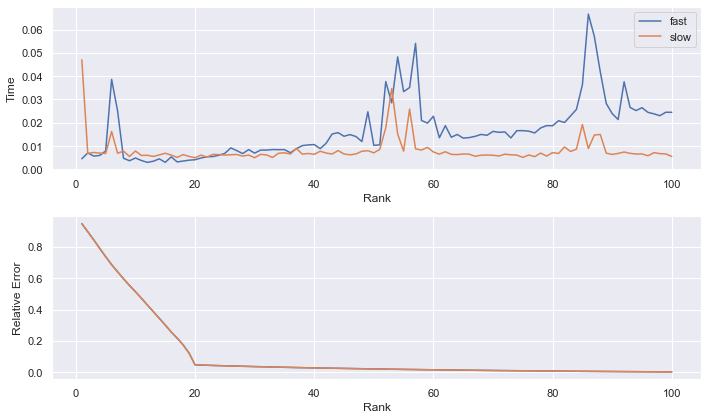

In [13]:
###############################################################################
# Display
sns.set()

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10, 6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks, timing_fast, '-', label='fast')
ax1.plot(ranks, timing_slow, '-', label='slow')
ax1.legend()

ax1.set_xlabel('Rank')
ax1.set_ylabel('Time')
ax2.plot(ranks, rel_error, '-')
ax2.plot(ranks, rel_error0, '-')
ax2.set_xlabel('Rank')
ax2.set_ylabel('Relative Error')
plt.tight_layout()
plt.show()

<font style="color:Royalblue">

La version "rapide" ne semble plus rapide que pour les faibles valeurs de k, tandis que la version "lente" semble de temps constant peut importe la valeur de k.

La version "rapide" calcule seulement avec les k premiers valeurs singulières, quand $k << min(n,m)$, elle retourne beaucoup moins de choses que l'autre, elle est donc plus "rapide". Alors que la version "lente" calculer toujours toutes les valeurs singulières. 

L'erreur relative semble diminuer rapidement jusqu'à $k = 20$, puis elle diminue très lentement jusqu'à être presque nulle pour $k = 199$.

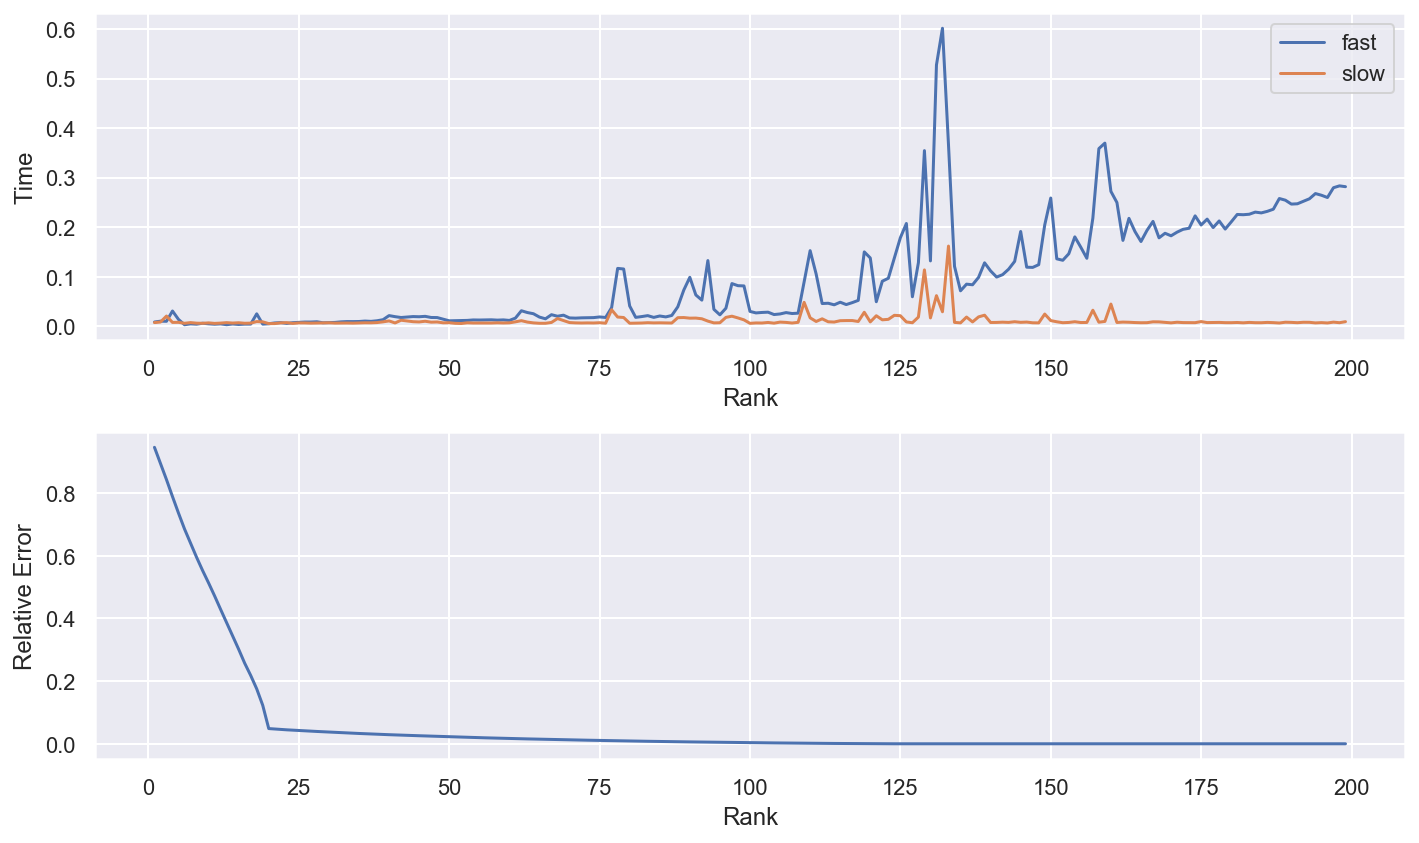

In [32]:
p = 200
r_noise = 100
r_signal = 20
intensity = 50
rng = np.random.RandomState(42)
X_noise = rng.randn(r_noise, p)
X_signal = rng.randn(r_signal, p)

gram_signal = np.dot(X_noise.T, X_noise) + intensity * np.dot(X_signal.T,
                                                              X_signal)
n_ranks = 199
ranks = np.arange(1, n_ranks + 1)
timing_fast = np.zeros(n_ranks)
timing_slow = np.zeros(n_ranks)
rel_error = np.zeros(n_ranks)

for k, rank in enumerate(ranks):
    #print(k, rank)
    t0 = time()
    gram_mat_k = rank_trunc(gram_signal, rank, fast=True)
    timing_fast[k] = time() - t0

    t0 = time()
    gram_mat_k = rank_trunc(gram_signal, rank, fast=False)
    timing_slow[k] = time() - t0

    # TODO: compute relative error with Frobenius norm
    rel_error[k] = np.linalg.norm(gram_mat_k - gram_signal,ord='fro')/np.linalg.norm(gram_signal,ord='fro')

# Display
sns.set()

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10, 6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks, timing_fast, '-', label='fast')
ax1.plot(ranks, timing_slow, '-', label='slow')
ax1.legend()

ax1.set_xlabel('Rank')
ax1.set_ylabel('Time')
ax2.plot(ranks, rel_error, '-')
ax2.set_xlabel('Rank')
ax2.set_ylabel('Relative Error')
plt.tight_layout()
plt.show()

<font style="color:Royalblue">
    
A partir de k=125, la version "rapide" deviens beaucoup moins efficace, cette version est plus adaptée aux matrices sparce avec un $k << min(n,m)$, car il ne retourne qu'un ndarray de valeurs singulières de taille (k,). 

## Question 4

On va implémenter l'algorithme de Random Kernel Features pour le noyau Gaussien.

In [15]:
def random_features(X_train, X_test, gamma, c=300, seed=44, Laplace=False):
    """Compute random kernel features

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    if Laplace==False:
        #Gaussian kernel
        rng = np.random.RandomState(seed)
        n_samples, n_features = X_train.shape

        W = rng.normal(0,np.sqrt(2*gamma),(n_features,c))
        b = rng.uniform(0,2*np.pi,(1,c))

        X_new_train = np.zeros((X_train.shape[0],c))
        X_new_test = np.zeros((X_test.shape[0],c))

        for i in range(X_train.shape[0]):
            X_new_train[i,:] = np.sqrt(2.0/c)*np.cos(np.dot(X_train[i,:],W) + b)

        for i in range(X_test.shape[0]):
            X_new_test[i,:] = np.sqrt(2.0/c)*np.cos(np.dot(X_test[i,:],W) + b)
    
    else:
        #Laplace Kernel
        rng = np.random.RandomState(seed)
        n_samples, n_features = X_train.shape
        #W in Cauchy distribution
        W = rng.standard_cauchy((n_features,c))
        b = rng.uniform(0,2*np.pi,(1,c))

        X_new_train = np.zeros((X_train.shape[0],c))
        X_new_test = np.zeros((X_test.shape[0],c))

        for i in range(X_train.shape[0]):
            X_new_train[i,:] = np.sqrt(2.0/c)*np.cos(np.dot(X_train[i,:],W) + b)

        for i in range(X_test.shape[0]):
            X_new_test[i,:] = np.sqrt(2.0/c)*np.cos(np.dot(X_test[i,:],W) + b)
    return X_new_train, X_new_test

## Question 5

On va maintenant appliquer cette méthode avec $c=300$.

Fitting SVC linear on 20000 samples...
done in 2.733s
Predicting with SVC linear on 40000 samples...
done in 0.019s
classification accuracy: 0.963

Accuracy :
Linear : 	0.917
RKF+rbf: 	0.963
SVC+rbf: 	0.980


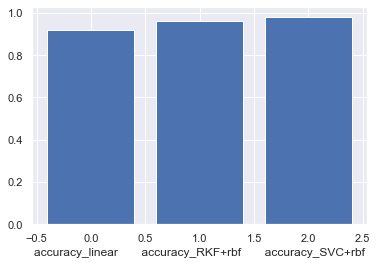


Time :
Linear : 	0.129s
RKF+rbf: 	2.753s
SVC+rbf: 	7.120s


<BarContainer object of 3 artists>

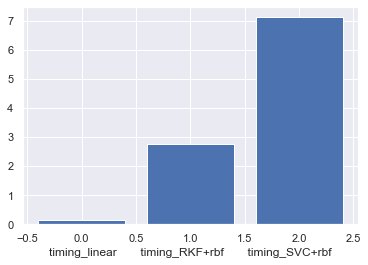

In [39]:
n_samples, n_features = X_train.shape
n_samples_test, _ = X_test.shape
gamma = 1. / n_features

t0 = time()
Z_train, Z_test = random_features(X_train, X_test, gamma, c=300, seed=44)

print("Fitting SVC linear on %d samples..." % n_samples)

clf = LinearSVC(dual=False)
clf.fit(Z_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC linear on %d samples..." % n_samples_test)
t1 = time()
accuracy_RKF = clf.score(Z_test, y_test)
print("done in %0.3fs" % (time() - t1))
timing_RKF = time() - t0
print("classification accuracy: %0.3f" % accuracy_RKF)

print("\nAccuracy :")
print("Linear : \t%0.3f" % accuracy_linear)
print("RKF+rbf: \t%0.3f" % accuracy_RKF)
print("SVC+rbf: \t%0.3f" % accuracy_kernel)
plt.xlabel("accuracy_linear       accuracy_RKF+rbf       accuracy_SVC+rbf")
plt.bar(range(3),(accuracy_linear,accuracy_RKF,accuracy_kernel))
plt.show()

print("\nTime :")

print("Linear : \t%0.3fs" % timing_linear)
print("RKF+rbf: \t%0.3fs" % timing_RKF)
print("SVC+rbf: \t%0.3fs" % timing_kernel)

plt.xlabel("timing_linear       timing_RKF+rbf       timing_SVC+rbf")
plt.bar(range(3),(timing_linear,timing_RKF,timing_kernel))


<font style="color:Royalblue">
En temps comme en précision, cette méthode RKF s'inscrit entre les deux considérées à la question 1 : elle est plus lente mais plus précise que la méthode sans noyau, et plus rapide mais moins précise que la méthode avec noyau.

## Question 6

On implémente la méthode de Nyström.

In [32]:
from sklearn.metrics.pairwise import rbf_kernel

def nystrom(X_train, X_test, gamma, c=500, k=200, seed=44):
    """Compute nystrom kernel approximation

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of points to sample for the approximation
    k : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    n_samples = X_train.shape[0]
    # Generates a random sample with replacement
    idx = rng.choice(n_samples, c, replace=1)

    X_train_idx = X_train[idx, :]
    W = rbf_kernel(X_train_idx, X_train_idx, gamma=gamma)
    
    #the best rand k approximation
    Vk, sigma_k, Vkt = svd(W)
    Vk = Vk[:, :k]
    Vkt = Vkt[:k, :]
    sigma_k = sigma_k[:k]

    M_k = np.dot(Vk, np.diag(1/np.sqrt(sigma_k)))

    C_train = rbf_kernel(X_train, X_train_idx, gamma=gamma)
    C_test = rbf_kernel(X_test, X_train_idx, gamma=gamma)

    X_new_train = np.dot(C_train, M_k)
    X_new_test = np.dot(C_test, M_k)

    return X_new_train, X_new_test

## Question 7

On va maintenant appliquer cette méthode également avec $c=500$ et $k=300$

Fitting SVC linear on 20000 samples...
done in 1.395s
Predicting with SVC linear on 40000 samples...
done in 0.018s
classification accuracy: 0.976

Accuracy :
LinearSVM        : 	0.917
SVM_rbf(Nyström) : 	0.976
SVM_rbf(RKF)     : 	0.963
SVM_rbf_Kernel   : 	0.980


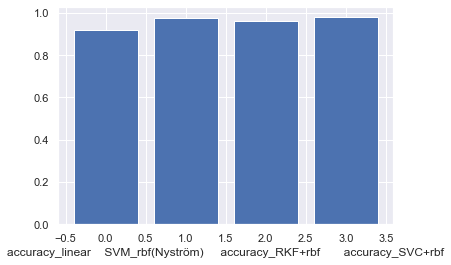


Time :
LinearSV         : 	0.129s
SVM_rbf(Nyström) : 	1.414s
SVM_rbf(RKF)     : 	2.753s
SVM_rbf_Kernel   : 	7.120s


<BarContainer object of 4 artists>

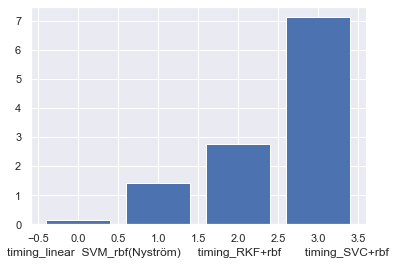

In [48]:
Z_train, Z_test = nystrom(X_train, X_test, gamma, c=500, k=300, seed=44)

print("Fitting SVC linear on %d samples..." % n_samples)
t0 = time()
clf = LinearSVC(dual=False)
clf.fit(Z_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC linear on %d samples..." % n_samples_test)
t1 = time()
accuracy_nystrom = clf.score(Z_test, y_test)
print("done in %0.3fs" % (time() - t1))
timing_nystrom = time() - t0
print("classification accuracy: %0.3f" % accuracy_nystrom)

print("\nAccuracy :")
print("LinearSVM        : \t%0.3f" % accuracy_linear)
print("SVM_rbf(Nyström) : \t%0.3f" % accuracy_nystrom)
print("SVM_rbf(RKF)     : \t%0.3f" % accuracy_RKF)
print("SVM_rbf_Kernel   : \t%0.3f" % accuracy_kernel)
plt.xlabel("accuracy_linear    SVM_rbf(Nyström)     accuracy_RKF+rbf       accuracy_SVC+rbf")
plt.bar(range(4),(accuracy_linear,accuracy_nystrom,accuracy_RKF,accuracy_kernel))
plt.show()
print("\nTime :")

print("LinearSV         : \t%0.3fs" % timing_linear)
print("SVM_rbf(Nyström) : \t%0.3fs" % timing_nystrom)
print("SVM_rbf(RKF)     : \t%0.3fs" % timing_RKF)
print("SVM_rbf_Kernel   : \t%0.3fs" % timing_kernel)
plt.xlabel("timing_linear  SVM_rbf(Nyström)     timing_RKF+rbf       timing_SVC+rbf")
plt.bar(range(4),(timing_linear,timing_nystrom,timing_RKF,timing_kernel))

<font style="color:Royalblue">
    
La méthode de l'approximation de Nyström semble efficace puisqu'elle est plus rapide que RKF tout en étant plus efficace que celle-ci. Elle atteint une précision comparable à celle de la méthode à noyau.
   
   
Avec le même numbre de samples   (features/columns), Nystöm a tendance d'avoir meilleur performance que RKF, alors qu'en général, RKF est moins cher à générer ( pas besoins de décomposition spectrale ni inversion de matrice)

## Question 8

On va maintenant réaliser une synthèse des performances des RKF et de Nystrom pour un ensemble de paramètres.

In [49]:
ranks = np.arange(20, 600, 50)
n_ranks = len(ranks)
timing_rkf = np.zeros(n_ranks)
timing_nystrom = np.zeros(n_ranks)
timing_rkf_laplace = np.zeros(n_ranks)

accuracy_nystrom = np.zeros(n_ranks)
accuracy_rkf = np.zeros(n_ranks)
accuracy_rkf_laplace = np.zeros(n_ranks)

# TODO: compute time and prediction scores for RKF and Nystrom with respect to c
# put results in timing_rkf, timing_nystrom, accuracy_rkf, accuracy_nystrom
print("Training SVMs for various values of c...")

for i, c in enumerate(ranks):
    t0 = time()
    Z_train, Z_test = random_features(X_train, X_test, gamma, c=c, seed=44)
    clf = LinearSVC(dual=False)
    clf.fit(Z_train, y_train)
    accuracy_rkf[i] = clf.score(Z_test, y_test)
    timing_rkf[i] = time() - t0

    t1 = time()
    Z_train, Z_test = nystrom(X_train, X_test, gamma, c=c, k=c-10, seed=44)
    clf = LinearSVC(dual=False)
    clf.fit(Z_train, y_train)
    accuracy_nystrom[i] = clf.score(Z_test, y_test)
    timing_nystrom[i] = time() - t1

    t2 = time()
    Z_train, Z_test = random_features(
        X_train, X_test, gamma, c=c, seed=44, Laplace=True)
    clf = LinearSVC(dual=False)
    clf.fit(Z_train, y_train)
    accuracy_rkf_laplace[i] = clf.score(Z_test, y_test)
    timing_rkf_laplace[i] = time() - t0



Training SVMs for various values of c...


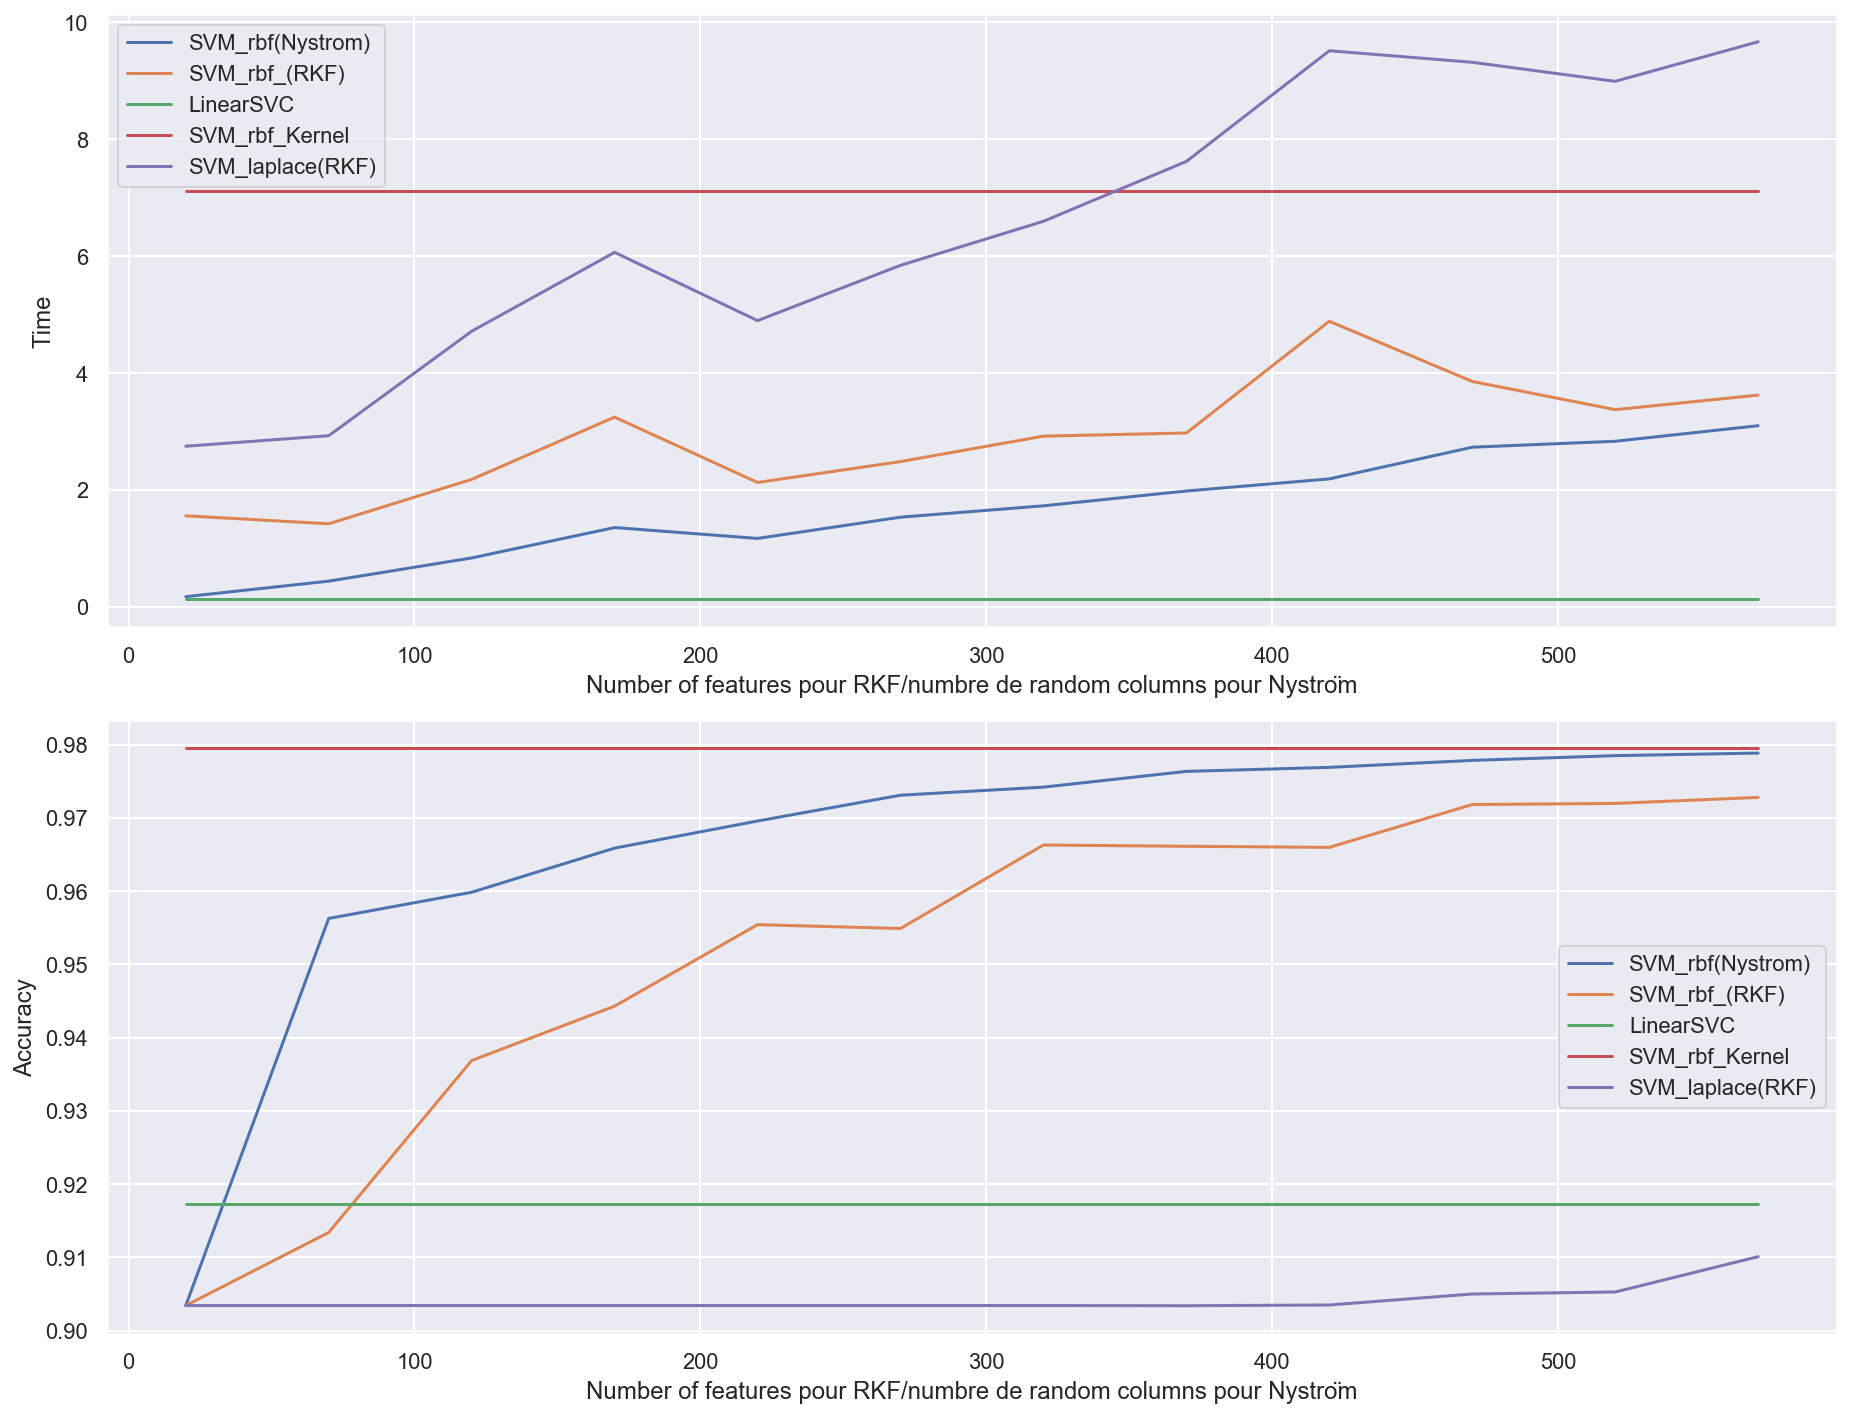

In [58]:
###############################################################################
# Display bis
sns.set()
f, axes = plt.subplots(ncols=1, nrows=2, figsize=(13,10))
ax1, ax2 = axes.ravel()

ax1.plot(ranks, timing_nystrom, '-', label='SVM_rbf(Nystrom)')
ax1.plot(ranks, timing_rkf, '-', label='SVM_rbf_(RKF)')
ax1.plot(ranks, timing_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax1.plot(ranks, timing_kernel * np.ones(n_ranks), '-', label='SVM_rbf_Kernel')
ax1.plot(ranks, timing_rkf_laplace * np.ones(n_ranks), '-', label='SVM_laplace(RKF)')
ax1.legend()
ax1.set_xlabel('Number of features pour RKF/numbre de random columns pour Nyström')
ax1.set_ylabel('Time')

ax2.plot(ranks, accuracy_nystrom, '-', label='SVM_rbf(Nystrom)')
ax2.plot(ranks, accuracy_rkf, '-', label='SVM_rbf_(RKF)')
ax2.plot(ranks, accuracy_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax2.plot(ranks, accuracy_kernel * np.ones(n_ranks), '-', label='SVM_rbf_Kernel')
ax2.plot(ranks, accuracy_rkf_laplace * np.ones(n_ranks), '-', label='SVM_laplace(RKF)')
ax2.set_xlabel('Number of features pour RKF/numbre de random columns pour Nyström')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.tight_layout()
plt.show()

<font style="color:Royalblue">
    
- Accuracy:

    - En termes d'accuracy, les méthodes Nystrom et RKF convergent toutes les deux vers le vrai SVM à noyau avec $O(1/\sqrt{c})$ convergence. (avec c le nombre de random features pour RKF, le nombre de random columns pour Nyström) 

    - la méthode par approximation de Nystrom converge plus rapidement vers la méthode par SVM à noyau (vers c = 500). En effet, Nyström peut avoir O(1/c) convergence quand eigengap de G est large [Yang et al., 2012] 

    - Globalement, on observe que la méthode Nystrom est meilleure que RKF, et ce peu importe le nombre de features considérées. Cependant, la guarantee d'approximation de Nyström est adaptive aux données, alors que RKF est indépendant aux données.

- Time:

    - Tandis qu'au niveau du temps de calcul, Nyström reste bien plus rapide même avec c = 500 (où elle est entre trois et quatre fois plus rapide sur l'échantillon considéré). 

    - Nyström et RKF sont plus rapides que le SVM à noyau, sauf Nyström avec noyau Laplacian quand 'c' est grand. 




## Bonus : Laplace(Nyström)
Laplace RKF déjà dans function RKF.

In [62]:
from sklearn.metrics.pairwise import laplacian_kernel

def laplace(X_train, X_test, gamma, c=500, k=200, seed=44):
    """Compute nystrom kernel approximation

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of points to sample for the approximation
    k : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    n_samples = X_train.shape[0]
    idx = rng.choice(n_samples, c)

    X_train_idx = X_train[idx, :]
    W = laplacian_kernel(X_train_idx, X_train_idx, gamma=gamma)
    
    Vk, sigma_k, Vkt = svd(W)
    Vk = Vk[:,:k]
    Vkt = Vkt[:k,:]
    sigma_k=sigma_k[:k]
    
    M_k = np.dot(Vk,np.diag(1/np.sqrt(sigma_k)))
    
    Ctrain = laplacian_kernel(X_train,X_train_idx)
    Ctest = laplacian_kernel(X_test,X_train_idx)
    
    X_new_train = np.dot(Ctrain,M_k)
    X_new_test = np.dot(Ctest,M_k)
    
    return X_new_train, X_new_test

In [63]:
ranks = np.arange(20, 600, 50)
n_ranks = len(ranks)
timing_rkf = np.zeros(n_ranks)
timing_nystrom = np.zeros(n_ranks)
timing_laplace = np.zeros(n_ranks)
timing_Nyströme_stack = np.zeros(n_ranks)

accuracy_nystrom = np.zeros(n_ranks)
accuracy_rkf = np.zeros(n_ranks)
accuracy_laplace = np.zeros(n_ranks)
accuracy_Nyströme_stack = np.zeros(n_ranks)

print("Training SVMs for various values of c...")

for i, c in enumerate(ranks):
    #print(i, c)
    t0 = time()
    Z_train, Z_test = random_features(X_train, X_test, gamma, c=c, seed=44)
    clf = LinearSVC(dual=False)
    clf.fit(Z_train, y_train)
    accuracy_rkf[i] = clf.score(Z_test, y_test)
    timing_rkf[i] = time() - t0

    t1 = time()
    Z_train, Z_test = nystrom(X_train, X_test, gamma, c=c, k=c-10, seed=44)
    clf = LinearSVC(dual=False)
    clf.fit(Z_train, y_train)
    accuracy_nystrom[i] = clf.score(Z_test, y_test)
    timing_nystrom[i] = time() - t1

    t2 = time()
    Z_train, Z_test = laplace(X_train, X_test, gamma, c=c, k=c-10, seed=44)
    clf = LinearSVC(dual=False)
    clf.fit(Z_train, y_train)
    accuracy_laplace[i] = clf.score(Z_test, y_test)
    timing_laplace[i] = time() - t2

    t3 = time()
    Z_train1, Z_test1 = nystrom(X_train, X_test, gamma, c=c, k=c-10, seed=44)
    Z_train2, Z_test2 = laplace(X_train, X_test, gamma, c=c, k=c-10, seed=44)
    Z_train = np.hstack((Z_train1, Z_train2))
    Z_test = np.hstack((Z_test1, Z_test2))
    clf = LinearSVC(dual=False)
    clf.fit(Z_train, y_train)
    accuracy_Nyströme_stack[i] = clf.score(Z_test, y_test)
    timing_Nyströme_stack[i] = time() - t3

    # TODO: compute time and prediction scores for RKF and Nystrom with respect to c
    # put results in timing_rkf, timing_nystrom, accuracy_rkf, accuracy_nystrom

Training SVMs for various values of c...


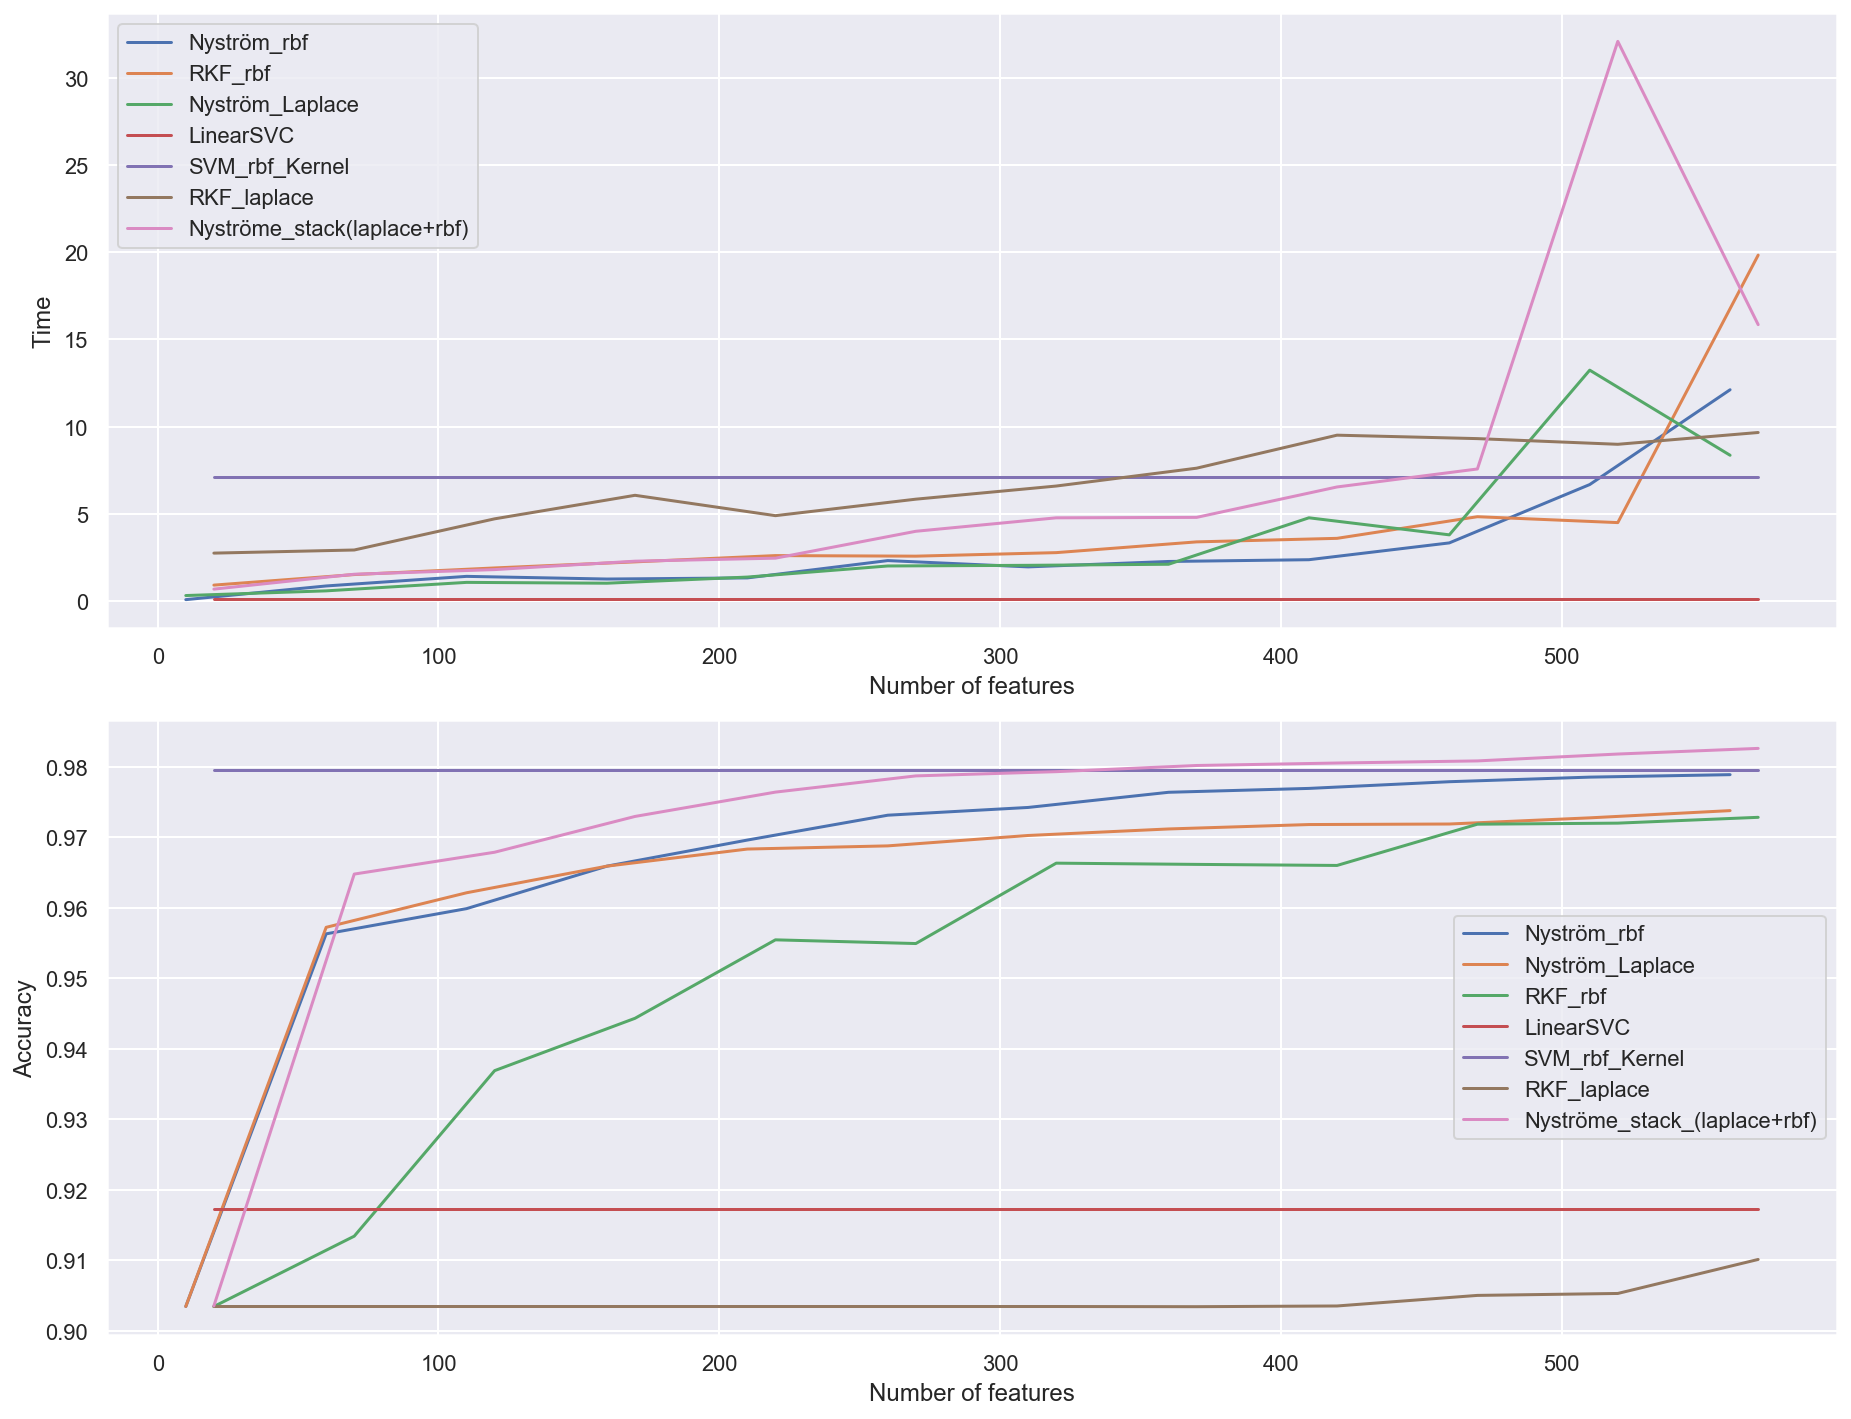

In [65]:
###############################################################################
# Display bis
sns.set()
f, axes = plt.subplots(ncols=1, nrows=2, figsize=(13,10))
ax1, ax2 = axes.ravel()

ax1.plot(ranks-10, timing_nystrom, '-', label='Nyström_rbf')
ax1.plot(ranks, timing_rkf, '-', label='RKF_rbf')
ax1.plot(ranks-10, timing_laplace, '-', label='Nyström_Laplace')
ax1.plot(ranks, timing_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax1.plot(ranks, timing_kernel * np.ones(n_ranks), '-', label='SVM_rbf_Kernel')
ax1.plot(ranks, timing_rkf_laplace * np.ones(n_ranks), '-', label='RKF_laplace')
ax1.plot(ranks, timing_Nyströme_stack * np.ones(n_ranks), '-', label='Nyströme_stack(laplace+rbf)')

ax1.set_xlabel('Number of features')
ax1.set_ylabel('Time')
ax1.legend()

ax2.plot(ranks-10, accuracy_nystrom, '-', label='Nyström_rbf')
ax2.plot(ranks-10, accuracy_laplace, '-', label='Nyström_Laplace')
ax2.plot(ranks, accuracy_rkf, '-', label='RKF_rbf')
ax2.plot(ranks, accuracy_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax2.plot(ranks, accuracy_kernel * np.ones(n_ranks), '-', label='SVM_rbf_Kernel')

ax2.plot(ranks, accuracy_rkf_laplace * np.ones(n_ranks), '-', label='RKF_laplace')
ax2.plot(ranks, accuracy_Nyströme_stack * np.ones(n_ranks), '-', label='Nyströme_stack_(laplace+rbf)')
ax2.set_xlabel('Number of features')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.tight_layout()
plt.show()



<font style="color:Royalblue">

- Time:

    - Avec le même noyau, Nyström est plus rapide que la technique de RKF et SVC kernel. Les temps d'excution d'Nyström avec noyau gaussien et noyau laplacien sont quasiment identiques. Enfin, Sklearn SVC API ne fournie pas de Laplace kernel, nous ne pouvons pas comparer avec Laplace(RKF/Nyström).

    - Avec le feature map en grand dimension, les méthodes d'approximation de noyaux ont tendance à prendre plus de temps que le SVM à noyau normal.

    - Le stacking de Nyströme_stack_(laplace+rbf) est le plus lent puisqu'on calcule les deux features map et stack avec numpy.


- Accuracy:

     - Avec notre dataset, la méthode de Nyström converge plus vite la méthode RKF avec les deux types de noyaux (Gaussian et Laplace). 
     
     - Le stacking des 2 noyaux Gaussian(Nyström) et Laplace(Nyström) converge le plus vite. En effet, la combinaison de features obtenus avec noyeau Gaussian(Nyström) et Laplace(Nyström) permets de faciliter l'apprentissage du modèle, qui donne le meilleur performance.
     
     
- Trade-off
   
    - Avec 300 features, nous avons une très bonne précision alors que nous avons une nette accéleration computationelle en calculant d'abord les features puis en les applicants à un sur classifieur linéaire.


# Conclusion
<font style="color:Royalblue">

\
    
Nous avons testé 

   - les features aléatoires (RKF) dont les produits scalaire approximent les noyaux Gaussien et Laplacien
   - les features obtenues par approximation de la matrice du noyau (Nyström)
   
Nous démontrons que ces features sont des outils puissants et économiques pour faire du large-scale supervised learning. 

Nous montrons empiriquement que fournir ces features comme entrées d'un classifier standard comme SVM produit des résultats competitifs en termes de précision et de temps d'apprentissage.

Il est à noter que la combinaison de ces features donne également de bonnes performances